# [IAFlash](https://entrepreneur-interet-general.etalab.gouv.fr/defis/2019/iaflash.html) simple exploration

## Example of image scrapping from the web

Here we quickly show how we can constitute a database of *labeled* images, by scrapping e.g. second-hand cars websites.  
Note that this is only an example, no data are downloaded, and the process depends on the website used. Also, this does not cover the next step consisting of cleaning the downloaded data depending on our goals, like removing pictures of cars' interiors for instance.

### Imports

In [1]:
import os
HOME = os.path.expanduser('~/')
HOST = os.uname()[1]
if HOST == 'Arthurs-MacBook-Pro.local':
    os.chdir(os.path.join(HOME, 'Documents/GitHub/EIG3_IAFlash/'))    # @home
else:
    raise ValueError('unknown host: {}'.format(HOST))
    
import re

from PIL import Image
import requests
from bs4 import BeautifulSoup

### Variables

In [2]:
# scrapping
url1 = 'https://www.leboncoin.fr/voitures/offres/ile_de_france/' # url of a search arround Paris on leboncoin
url2 = 'https://www.autoscout24.fr/lst?sort=standard&desc=0&offer=J%2CU%2CO%2CD&ustate=N%2CU&cy=F&atype=C' # url of the widest search on autoscout24

### Web scrapping

We use the [`request`](http://docs.python-requests.org/en/master/) and [`BeautifulSoup`](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) packages.

In [3]:
# for leboncoin: need permissions :(

r = requests.get(url1)
print(r.status_code)
print(r.headers['content-type'])
print(r.encoding)
print(r.text)

403
text/html, text/html
ISO-8859-1
<!--
Need permission to access data? Contact: DataAccess@datadome.co
-->
<html><head><title>You have been blocked</title><style>#cmsg{animation: A 1.5s;}@keyframes A{0%{opacity:0;}99%{opacity:0;}100%{opacity:1;}}</style></head><body style="margin:0"><p id="cmsg">Please enable JS and disable any ad blocker</p><script>var dd={'cid':'AHrlqAAAAAMA0pm5VoJrJc8ATsJTSw==','hsh':'05B30BD9055986BD2EE8F5A199D973'}</script><script src="https://ct.datadome.co/c.js"></script></body></html>



200
text/html; charset=UTF-8
UTF-8
<!DOCTYPE html>
<html lang="fr-FR">
 <head>
  <meta charset="utf-8"/>
  <title>
   Voitures d'occasion sur AutoScout24
  </title>
  <link href="https://secure.pic.autoscout24.net" rel="dns-prefetch"/>
  <link href="https://www.googletagmanager.com" rel="dns-prefetch"/>
  <link href="https://www.google-analytics.com" rel="dns-prefetch"/>
  <meta content="IE=Edge;chrome=1" http-equiv="X-UA-Compatible"/>
  <meta content="width=device-width, initial-scale=1.0" name="viewport"/>
  <meta content="yes" name="mobile-web-app-capable"/>
  <meta content="yes" name="apple-mobile-web-app-capable"/>
  <meta content="" name="apple-mobile-web-app-title"/>
  <meta content="black" name="apple-mobile-web-app-status-bar-style"/>
  <meta content="Vous trouverez ici l'offre la plus complète de voitures d'occasion, AutoScout24 le plus grand site auto d'Europe." name="description"/>
  <style>
   .as24-custom-dropdown.sc-input{padding:0;position:relative;background-color:#fff
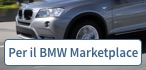
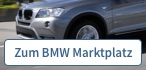
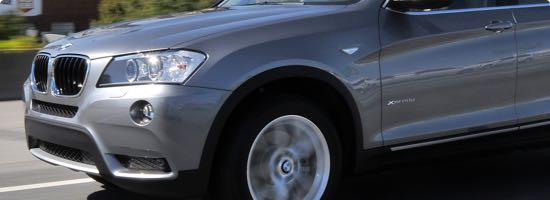

In [4]:
# but let's take a less known site, and it's ok

r = requests.get(url2)
print(r.status_code)
print(r.headers['content-type'])
print(r.encoding)
html = r.text
soup = BeautifulSoup(html)

# -> explore this manually to find the balises that contain relevant information
print(soup.prettify())

In [5]:
# model names are in the text balises 'h2', with class 'cldt-summary-makemodel sc-font-bold sc-ellipsis'

models_balises = soup.find_all('h2',attrs={'class':'cldt-summary-makemodel sc-font-bold sc-ellipsis'})
models = [x.text for x in models_balises]
nbModels = len(models)

In [6]:
# multiple urls are in the 'data-images' attribute of balises 'as24-listing-summary-image'

imgUrlList_balises = soup.find_all('as24-listing-summary-image',attrs={'class':'shine'})
imgUrlList = []
for x in imgUrlList_balises:
    urls = x['data-images'] # 'data-images' actually contains multiple urls, that we must split and clean to make a list
    urlList = urls.split(',')
    urlListClean = [re.findall('(.*)/{size}.{format}',u)[0] for u in urlList]
    imgUrlList.append(urlListClean)
nbUrls = len(imgUrlList)

In [ ]:
# example of urls
i = 2
print(models[i])
for u in imgUrlList[i]:
    print(u)

Renault Master
https://prod.pictures.autoscout24.net/listing-images/306a5880-a46a-4ccd-8521-7349877035bb_1c8432e9-8993-4e70-b8ac-4019b114e0a7.jpg
https://prod.pictures.autoscout24.net/listing-images/306a5880-a46a-4ccd-8521-7349877035bb_538a299d-a8be-4be0-865f-1717a978e188.jpg
https://prod.pictures.autoscout24.net/listing-images/306a5880-a46a-4ccd-8521-7349877035bb_75d23c95-1731-4ae7-bec3-26b5e77c12d1.jpg
https://prod.pictures.autoscout24.net/listing-images/306a5880-a46a-4ccd-8521-7349877035bb_20d1268d-8525-4e34-8bee-2bf56848f5e4.jpg




----- Autres -----


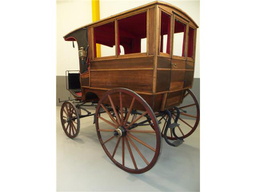

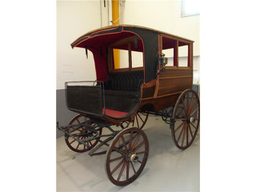

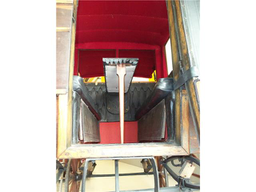

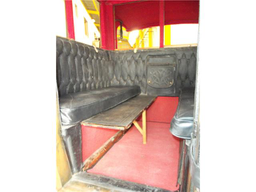

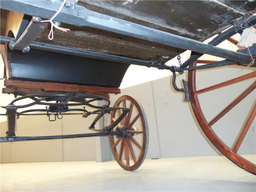

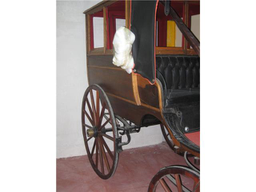

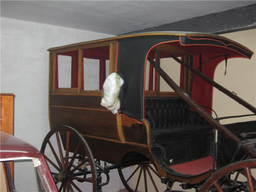

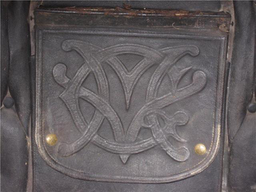

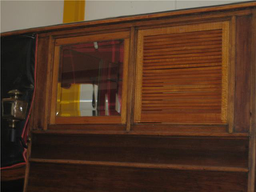

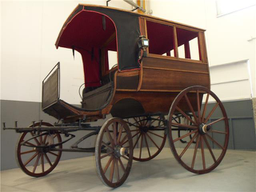

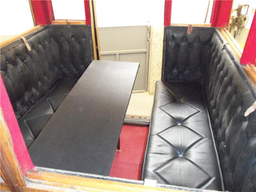

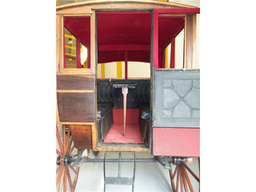

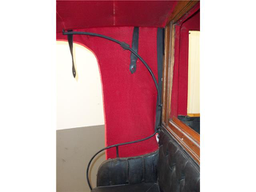

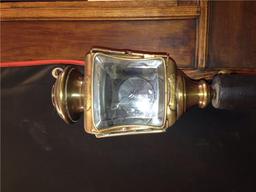

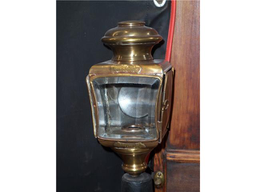



----- Ford Focus -----


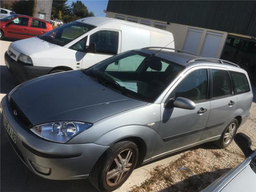

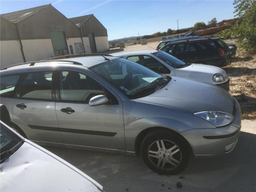

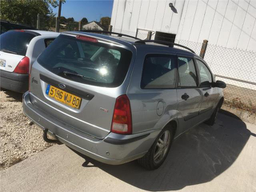

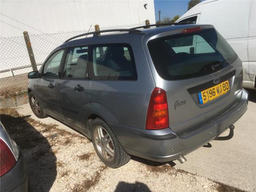



----- Renault Master -----


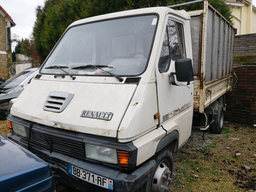

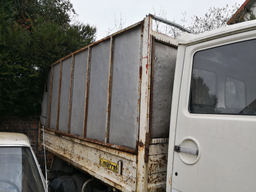

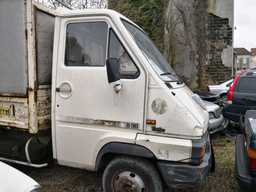

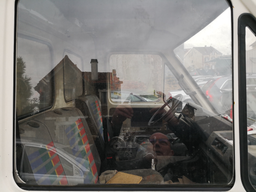



----- Peugeot 206 -----


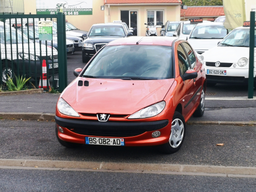

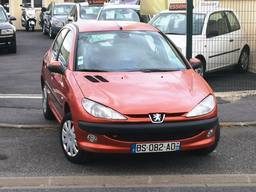

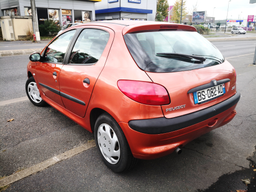

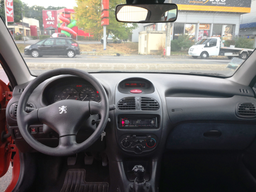

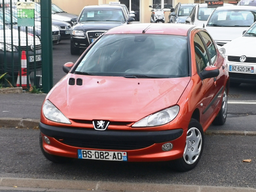

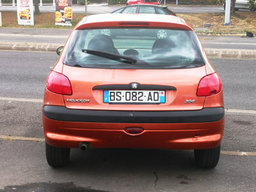

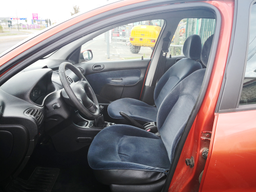

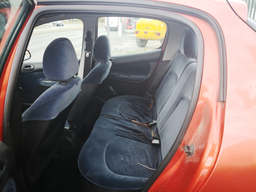

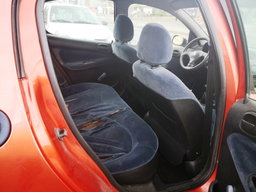

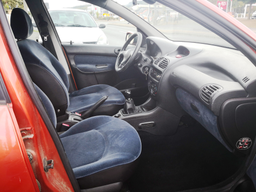



----- Volvo XC70 -----


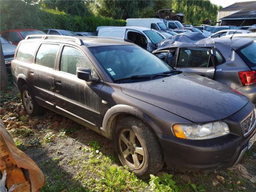

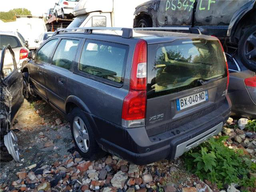

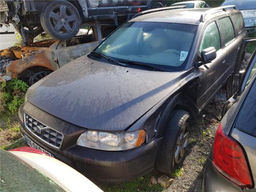

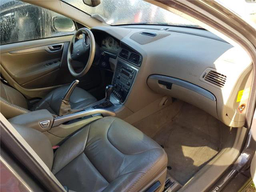



----- Opel Zafira -----


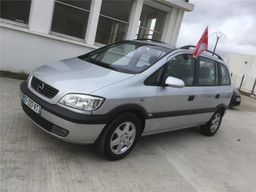

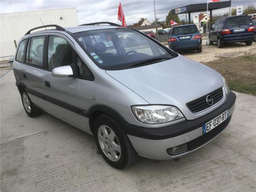

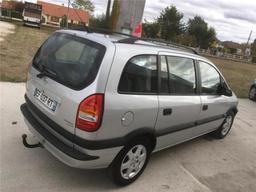

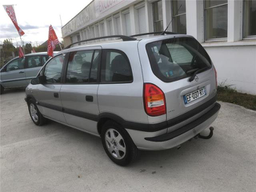

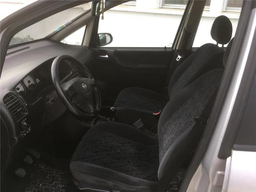

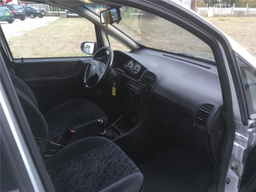

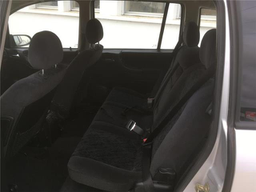

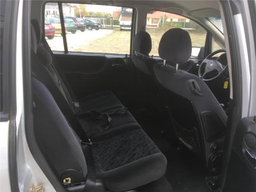

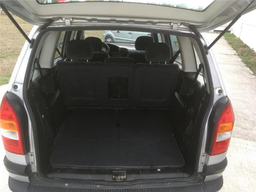



----- Renault Clio -----


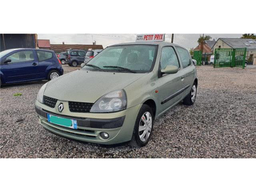

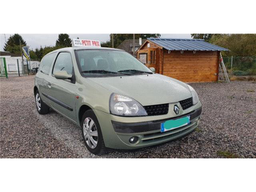

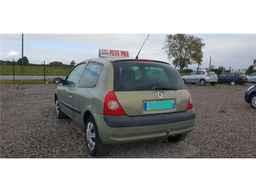

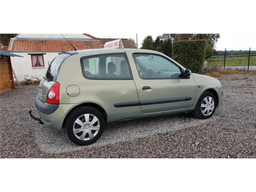

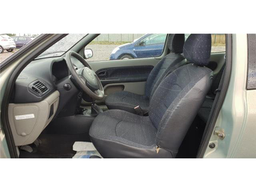

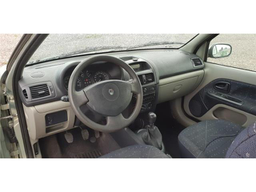



----- Peugeot 406 -----


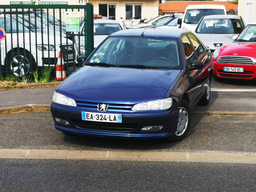

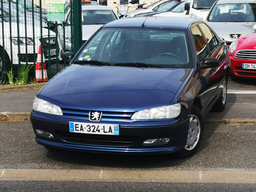

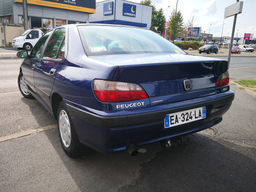

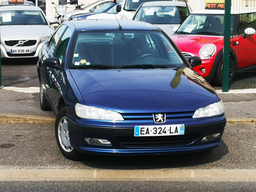

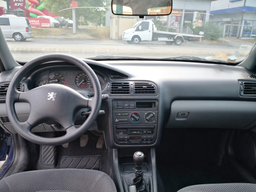

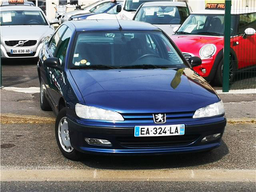

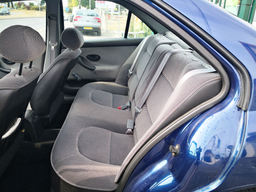

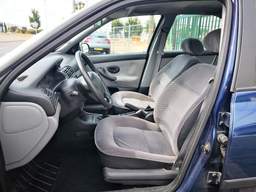

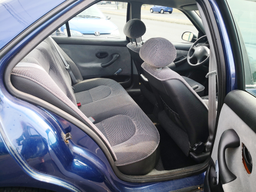

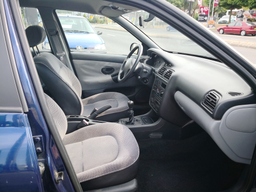



----- Renault Clio -----


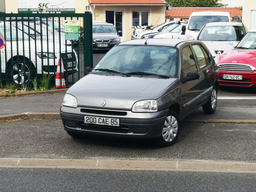

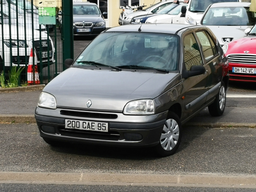

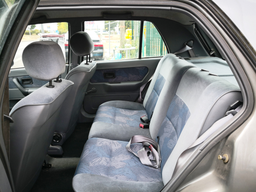

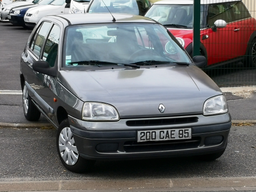

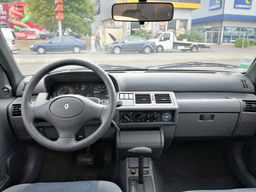

In [ ]:
# scrapping per se

# NB: we dont't save the images to disk here,
# the point is only to show it is possible to
# download labeled images!

if nbModels != nbUrls:
    raise ValueError('inconsistent numbers of models vs. url lists: {} vs. {}'.format(nbModels, nbUrls))

for i in range(nbModels):
    print('\n\n----- {} -----'.format(models[i]))
    for u in imgUrlList[i]:
        u_r = requests.get(u, stream=True)
        u_r.raw.decode_content = True # handle spurious Content-Encoding
        im = Image.open(u_r.raw)
        im.thumbnail((2**8,2**8), Image.ANTIALIAS) # just to ease vizualization here (acts inplace)
        display(im)